In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
import joblib, pickle

In [2]:
# Load data

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [7]:
# Exploratory Data Analysis (EDA)

print(train.info())
print(train.describe())
print(train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB
None
                  id   Compartments  Weight Capacity (kg)          Price
count  300000.000000  300000.000000         299862.000000  300000.000000

In [8]:
print(train.head())

   id         Brand Material    Size  Compartments Laptop Compartment  \
0   0      Jansport  Leather  Medium           7.0                Yes   
1   1      Jansport   Canvas   Small          10.0                Yes   
2   2  Under Armour  Leather   Small           2.0                Yes   
3   3          Nike    Nylon   Small           8.0                Yes   
4   4        Adidas   Canvas  Medium           1.0                Yes   

  Waterproof      Style  Color  Weight Capacity (kg)      Price  
0         No       Tote  Black             11.611723  112.15875  
1        Yes  Messenger  Green             27.078537   68.88056  
2         No  Messenger    Red             16.643760   39.17320  
3         No  Messenger  Green             12.937220   80.60793  
4        Yes  Messenger  Green             17.749338   86.02312  


In [9]:
# Drop 'id' column

train.drop(columns=["id"], inplace=True)
test_ids = test["id"]
test.drop(columns=["id"], inplace=True)

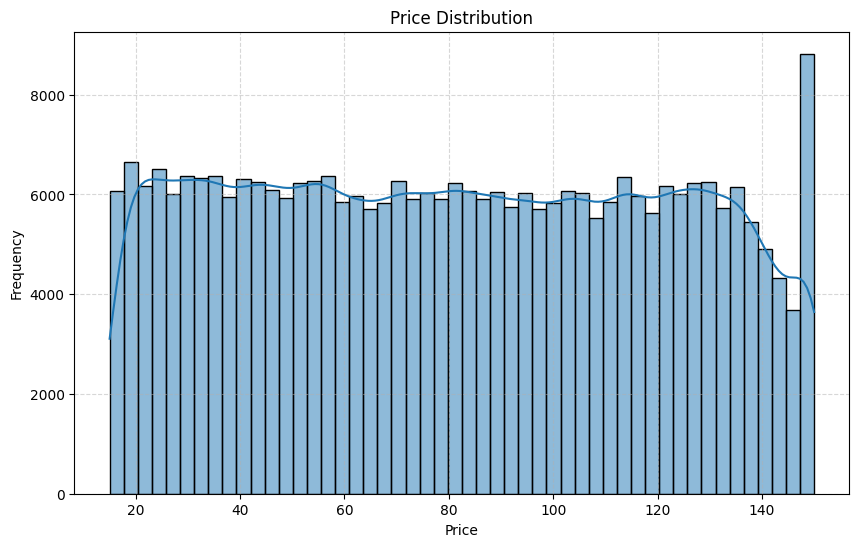

In [10]:
# Distribution of Price 

plt.figure(figsize=(10,6))
sns.histplot(train["Price"], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)  
plt.show()

In [11]:
# Identify categorical and numerical columns

categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
numerical_cols = [col for col in train.columns if train[col].dtype != 'object' and col != "Price"]

In [12]:
# Handle missing values

imputer = ColumnTransformer([
    ('num_imputer', SimpleImputer(strategy='median'), numerical_cols),
    ('cat_imputer', SimpleImputer(strategy='most_frequent'), categorical_cols)
])

train[numerical_cols + categorical_cols] = imputer.fit_transform(train[numerical_cols + categorical_cols])
test[numerical_cols + categorical_cols] = imputer.transform(test[numerical_cols + categorical_cols])

In [13]:
# Encode categorical features

encoder = LabelEncoder()
for col in categorical_cols:
    train[col] = encoder.fit_transform(train[col])
    test[col] = encoder.transform(test[col])

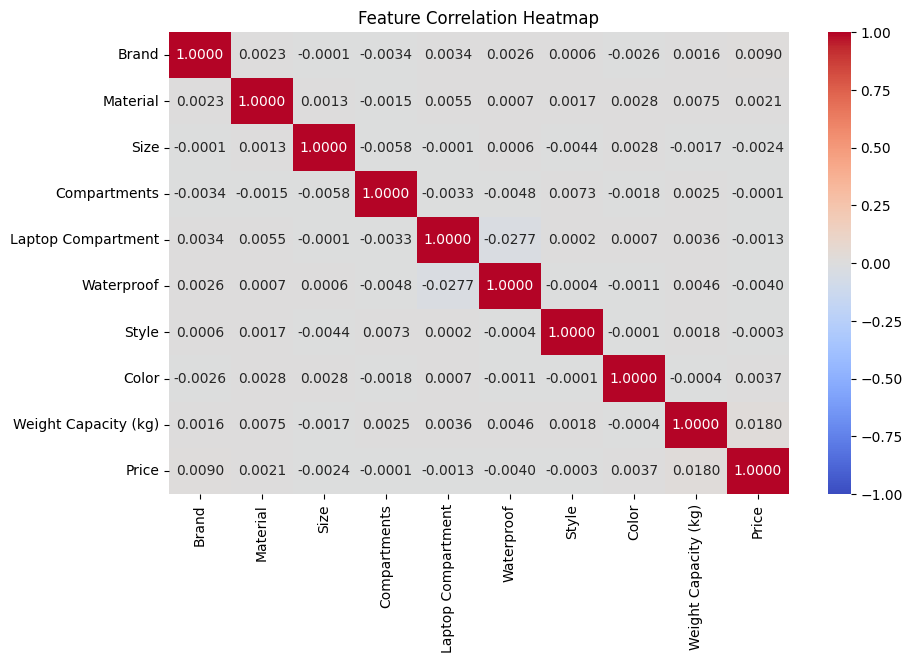

In [14]:
# Feature Correlation Heatmap

plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm", fmt='.4f', vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

In [15]:
# Standardize numerical features

scaler = StandardScaler()
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

In [16]:
# Split data into train and validation sets

X = train.drop(columns=["Price"])
y = train["Price"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Train Random Forest model

rf = RandomForestRegressor(n_estimators=300, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=300, random_state=42)

In [18]:
# Train XGBoost model

xgb = XGBRegressor(n_estimators=100, learning_rate=0.03, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

<Figure size 1000x600 with 0 Axes>

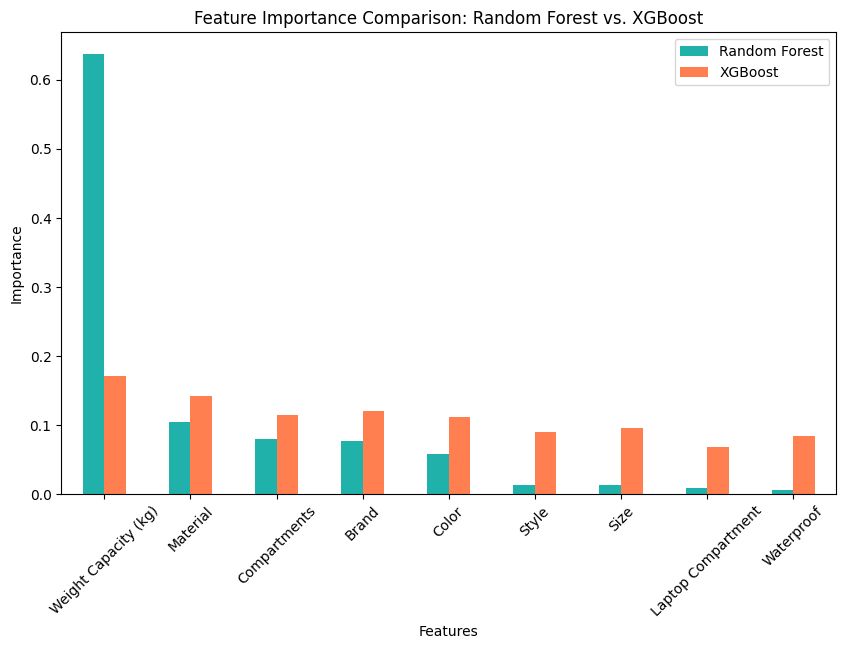

In [19]:
# Feature Importance Analysis

plt.figure(figsize=(10,6))
rf_importance = pd.Series(rf.feature_importances_, index=X.columns)
xgb_importance = pd.Series(xgb.feature_importances_, index=X.columns)

importance_df = pd.DataFrame({
    "Random Forest": rf_importance,
    "XGBoost": xgb_importance
}).sort_values(by="Random Forest", ascending=False)

importance_df.plot(kind="bar", figsize=(10,6), color=["lightseagreen", "coral"])
plt.title("Feature Importance Comparison: Random Forest vs. XGBoost")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

In [20]:
# Train Neural Network (ANN) model

ann = Sequential([
    Input(shape=(X_train.shape[1],)),  
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),  
    Dropout(0.3),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

ann.compile(optimizer=Adam(learning_rate=0.001), loss=Huber())

callbacks = [EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),  
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)]

ann.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_valid, y_valid), verbose=1, callbacks=callbacks)

Epoch 1/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 37.0455 - val_loss: 34.0045 - learning_rate: 0.0010
Epoch 2/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 34.7053 - val_loss: 33.9262 - learning_rate: 0.0010
Epoch 3/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 34.4257 - val_loss: 34.0046 - learning_rate: 0.0010
Epoch 4/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 34.3277 - val_loss: 33.6951 - learning_rate: 0.0010
Epoch 5/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 34.0087 - val_loss: 33.4459 - learning_rate: 0.0010
Epoch 6/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 33.8977 - val_loss: 33.3867 - learning_rate: 0.0010
Epoch 7/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 33.7444 - val_loss: 33.5026 - learning_rate: 0.0010
Epoch 8/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - loss: 33.6956 - val_loss: 33.2944 - learning_rate: 0.0010
Epoch 9/150
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - loss: 33.6346 

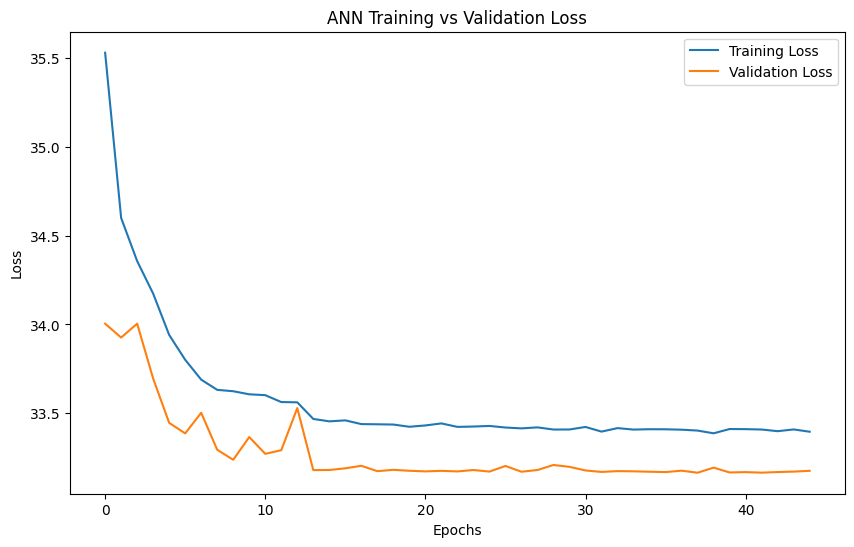

In [21]:
# ANN Training vs Validation Loss Curve

plt.figure(figsize=(10,6))
plt.plot(ann.history.history["loss"], label="Training Loss")
plt.plot(ann.history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Training vs Validation Loss")
plt.legend()
plt.show()